# Endometriosis Risk Assessment Model
This project explores the development of a symptom-based risk assessment model for endometriosis. Since endometriosis is difficult to diagnose without invasive procedures, my goal was to build a model that helps identify individuals at higher risk based on symptoms.

## Project Objectives
- Perform **Exploratory Data Analysis (EDA)** to understand symptom relationships.
- Engineer relevant features for predictive modeling.
- Compare multiple machine learning models to find the best **risk assessment approach**.
- Optimize the model for **high recall**, minimizing undiagnosed cases.

In [34]:
# Importing necessary libraries for data analysis, visualization, and machine learning.
# These will help with dataset exploration, preprocessing, and model training.

# Data Handling
import pandas as pd
import numpy as np
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, mutual_info_classif

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Explainability
import shap

import warnings
warnings.filterwarnings('ignore')

In [15]:
# Loading the dataset into a DataFrame.
# I will first check its structure to understand the feature types and distributions.
df = pd.read_csv("C:\\Users\\HP\\.cache\\kagglehub\\datasets\\michaelanietie\\endometriosis-dataset\\versions\\1\\structured_endometriosis_data.csv")

# Checking dataset structure: This will show column names, types, and missing values (if any).
df.info()

# Displaying the first few rows to get a preview of the dataset.
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        10000 non-null  int64  
 1   Menstrual_Irregularity     10000 non-null  int64  
 2   Chronic_Pain_Level         10000 non-null  float64
 3   Hormone_Level_Abnormality  10000 non-null  int64  
 4   Infertility                10000 non-null  int64  
 5   BMI                        10000 non-null  float64
 6   Diagnosis                  10000 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 547.0 KB


,Age,Menstrual_Irregularity,Chronic_Pain_Level,Hormone_Level_Abnormality,Infertility,BMI,Diagnosis
0,24,1,8.361531,0,0,19.451314,0
1,37,1,4.995508,0,0,22.388436,0
2,46,1,3.363996,1,0,21.320443,0
3,32,1,5.246037,0,0,20.177715,1
4,28,1,3.898932,1,0,23.538103,1


# Exploratory Data Analysis (EDA)
Before building our model, I need to explore the dataset to understand patterns, correlations, and potential issues.  
I'll focus on:
- Checking missing values and outliers
- Analyzing feature distributions
- Investigating relationships between symptoms
- Understanding how strongly features correlate with the diagnosis

Missing values per column:
 Age                          0
Menstrual_Irregularity       0
Chronic_Pain_Level           0
Hormone_Level_Abnormality    0
Infertility                  0
BMI                          0
Diagnosis                    0
dtype: int64


<Figure size 1200x600 with 0 Axes>

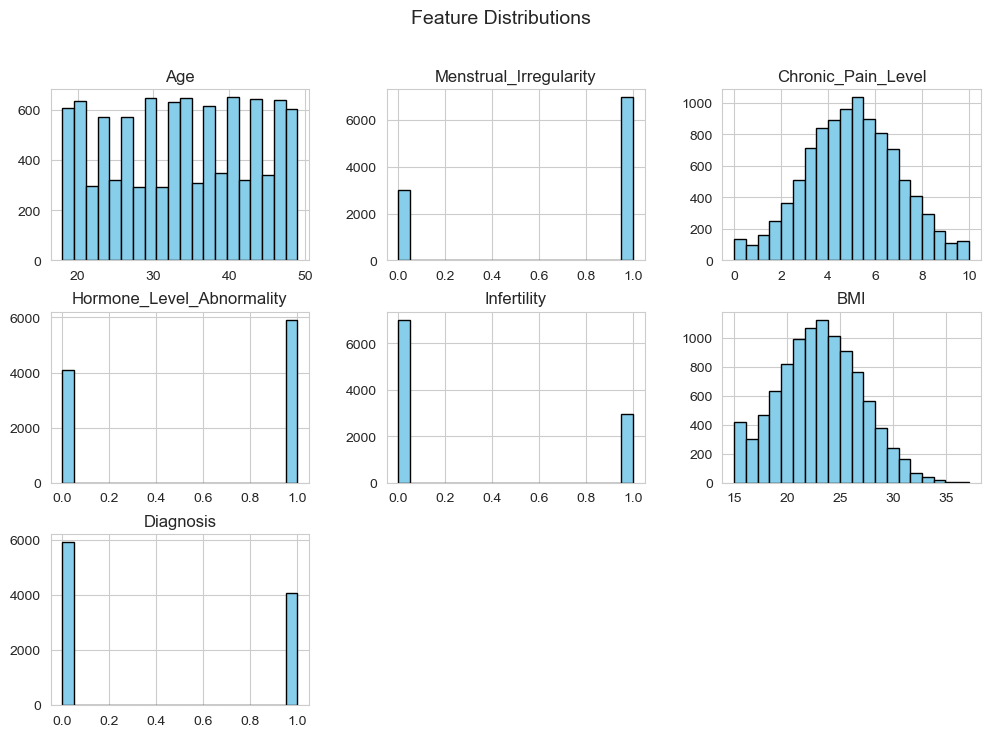

In [16]:
# First, I check for missing values in the dataset.
# This helps identify whether any features need imputation before model training.
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Now, I visualize the distribution of numeric features.
# This will help me detect skewed distributions, outliers, or imbalanced variables.
plt.figure(figsize=(12, 6))
df.hist(bins=20, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

## Initial Observations

### 1. Age Distribution
- The dataset includes a broad range of ages, roughly evenly distributed across the reproductive years.
- No skewness is observed.

### 2. Menstrual Irregularity
- The feature is binary, with more individuals with menstrual irregularity in the set.

### 3. Chronic Pain Level
- This feature follows a normal distribution, with most values concentrated around the mid-range (4-7).
- Extreme values (0 and 10) are less common, indicating fewer cases of no pain or very severe pain.

### 4. Hormone Level Abnormality
- A binary feature, showing a relatively even distribution of normal vs. abnormal hormone levels, but those with abnormal prevail.

### 5. Infertility
- Another binary feature, but with a noticeable imbalance, where more individuals do not report infertility.

### 6. BMI Distribution
- The BMI feature exhibits a slightly right-skewed distribution, meaning a larger proportion of individuals have BMIs in the normal to slightly overweight range.

### 7. Diagnosis (Target Variable)
- The dataset is imbalanced, there are more undiagnosed cases.
- This imbalance may influence model performance and should be considered in further steps.

## Key Takeaways
- The dataset includes both continuous and categorical variables, requiring appropriate handling in preprocessing.
- Chronic pain levels and BMI follow clear distributions, while binary features are differently imbalanced.
- The class imbalance in the diagnosis label will need to be addressed during modeling, possibly through class weighting or resampling.

## Target Variable Distribution (Diagnosis)

Understanding the distribution of the target variable (`Diagnosis`) is essential for evaluating class balance in the dataset. The plot below displays the count of diagnosed (1) and undiagnosed (0) cases.

Observations:
- The dataset has an imbalance, with **fewer diagnosed cases (1) than undiagnosed cases (0)**.
- The percentage distribution is displayed below the chart to quantify this imbalance.

This imbalance may influence model performance, potentially biasing predictions toward the majority class. If the imbalance is significant, techniques like class weighting or resampling may be necessary.


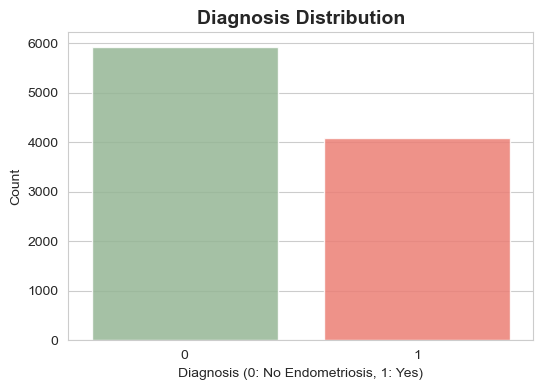

Diagnosis Distribution (%):
Diagnosis
0    59.21
1    40.79
Name: proportion, dtype: float64


In [17]:
# Visualizing the distribution of the target variable (Diagnosis).
# This will help assess class balance in the dataset.

plt.figure(figsize=(6,4))  # Define figure size for better readability
sns.set_style("whitegrid")  # Apply a subtle grid background for clarity

# Create a count plot to visualize the number of diagnosed and undiagnosed cases
sns.countplot(
    data=df, 
    x='Diagnosis',  # Target variable
    hue='Diagnosis',  # Assign hue to the same variable as x
    palette=['#8FBC8F', '#FF6F61'],  # Define colors for better visual separation
    alpha=0.85,
    legend=False  # Remove legend since x and hue are the same
)

# Add plot labels and title for better understanding
plt.title('Diagnosis Distribution', fontsize=14, fontweight='bold')  # Title of the plot
plt.xlabel('Diagnosis (0: No Endometriosis, 1: Yes)', fontsize=10)  # X-axis label
plt.ylabel('Count', fontsize=10)  # Y-axis label
plt.show()  # Display the plot

# Calculate and display the percentage distribution of diagnosed vs. undiagnosed cases.
diagnosis_counts = df['Diagnosis'].value_counts(normalize=True) * 100
print("Diagnosis Distribution (%):")
print(diagnosis_counts)  # Show the percentage of each class

### Target Variable Distribution: Diagnosis

The bar chart visualizes the distribution of the diagnosis variable, indicating the proportion of cases diagnosed with endometriosis (`1`) versus those without a diagnosis (`0`). The percentage breakdown is:

- **59.21%** of cases are labeled as **No Endometriosis** (`0`).
- **40.79%** of cases are labeled as **Endometriosis** (`1`).

#### Key Observations:
1. The dataset is **imbalanced**, with more non-endometriosis cases than diagnosed cases.
2. The imbalance is **not extreme** (roughly 60-40), but still significant enough to impact model training.
3. Since endometriosis is difficult to diagnose without invasive procedures, this proportion may reflect real-world diagnostic patterns.
4. The imbalance should be considered when selecting evaluation metrics. Accuracy alone may not be a reliable measure of performance.

#### Next Steps:
- Consider **class weighting** in model training to prevent bias toward the majority class.
- Evaluate **precision and recall** rather than just accuracy, since false negatives (missed diagnoses) are critical in a medical context.
- Further explore the relationship between symptoms and diagnosis to identify key predictive features.

## Feature Correlation Analysis
I will analyze how different features relate to the diagnosis.  
This will help me:
- Identify which symptoms are most strongly linked to endometriosis.
- Detect multicollinearity (when features are too similar, causing redundancy).
- Select the most relevant features for model training.

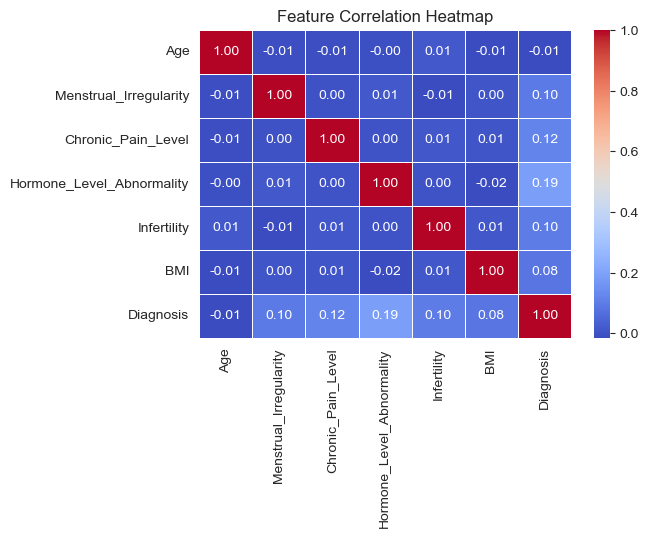

In [18]:
# Now, I generate a correlation heatmap to see how features are related.
# This helps detect multicollinearity, where features are too similar to each other, and see which features have a stronger link to the diagnosis.
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Feature Correlation Analysis

The heatmap above displays the correlation between numerical features in the dataset. The values range from -1 to 1, where:
- **1.0** indicates a perfect positive correlation.
- **-1.0** indicates a perfect negative correlation.
- **0** indicates no correlation.

#### Observations:
- Most feature correlations are relatively low, suggesting that the dataset does not contain highly redundant numerical variables.
- **Hormone Level Abnormality shows the strongest correlation with Diagnosis (0.19)**, indicating that hormone irregularities may play a role in predicting endometriosis.
- **Chronic Pain Level (0.12), Menstrual Irregularity (0.10), and Infertility (0.10) also show relatively strong correlations with Diagnosis** but they are still weak, suggesting that these symptoms contribute but do not strongly determine the condition on their own.
- **Age and BMI have negligible correlations with Diagnosis**, meaning they do not provide much direct predictive power individually.
- **No strong multicollinearity is present** among the numerical features, meaning that feature selection will focus on other methods such as interaction terms or domain knowledge rather than correlation-based removal.

#### Implications for Model Development:
- Since individual symptom correlations are weak, a model that considers **combinations of symptoms** may perform better than one relying on single features.
- Additional feature engineering (such as symptom grouping) may improve prediction performance.

## Outlier Analysis with Boxplots

In this section, I will analyze the continuous variables (Age, BMI, and Chronic Pain Level) using boxplots. The goal is to visually inspect the data for potential outliers that might affect model performance. Identifying and handling outliers is crucial for robust statistical analysis and reliable model training.

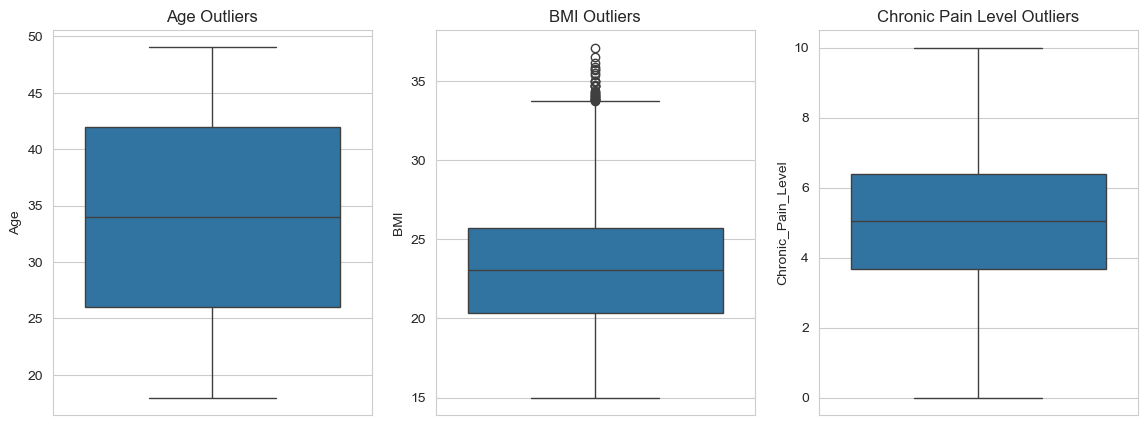

In [19]:
# I create a figure with three subplots to visualize outliers for different continuous features.
plt.figure(figsize=(14, 5))  # Set the overall figure size for clarity

# First subplot: Visualizing outliers in Age
plt.subplot(1, 3, 1)  # Arrange the subplots: 1 row, 3 columns, first subplot
sns.boxplot(y=df['Age'])  # Create a boxplot for the 'Age' column to inspect its distribution and outliers
plt.title('Age Outliers')  # Title the subplot to indicate it shows age outliers

# Second subplot: Visualizing outliers in BMI
plt.subplot(1, 3, 2)  # Move to the second subplot in the same row
sns.boxplot(y=df['BMI'])  # Create a boxplot for the 'BMI' column to check for extreme values
plt.title('BMI Outliers')  # Title this subplot accordingly

# Third subplot: Visualizing outliers in Chronic Pain Level
plt.subplot(1, 3, 3)  # Move to the third subplot in the same row
sns.boxplot(y=df['Chronic_Pain_Level'])  # Create a boxplot for the 'Chronic_Pain_Level' column to detect any outliers
plt.title('Chronic Pain Level Outliers')  # Title this subplot to reflect its content

plt.show()  # Render all the subplots in the figure

### Outlier Analysis

The boxplots above visualize the distribution and presence of potential outliers in three key numerical features: **Age, BMI, and Chronic Pain Level**.

- **Age:** The distribution appears relatively even, with no outliers. 
  
- **BMI:** This feature has a noticeable number of **upper outliers**, represented by individual points above the upper whisker. These indicate cases with particularly high BMI values that exceed the typical range observed in the dataset.
  
- **Chronic Pain Level:** The distribution shows outliers.

### Key Takeaways:
- **BMI contains potential outliers**, which may require further investigation. Maybe extreme BMI values somehow correlate with positive diagnosis.
- **No extreme anomalies in Age and Chronic Pain Level** were detected, meaning their distributions are fine and will not require modifications.

## T-Test Analysis for Numerical Features

To determine whether there is a **statistically significant difference** between diagnosed and undiagnosed cases for numerical features, a **T-test** is performed. The **T-test** compares the means of two groups (**Diagnosis = 0 vs. Diagnosis = 1**) to check if the difference is significant.
- It helps identify whether a feature is **strongly associated** with the diagnosis.
- If a feature has a **low p-value (< 0.05)**, it suggests that the difference in means is **statistically significant** and not due to random chance.
- Features with **significant differences** may be more predictive for the classification model.

In [20]:
# List of numerical features to analyze using T-tests
numeric_features = ['Age', 'Menstrual_Irregularity', 'Chronic_Pain_Level', 
                    'Hormone_Level_Abnormality', 'Infertility', 'BMI']

# Create an empty list to store T-test results for each feature
t_test_results = []

# Loop through each numeric feature and perform a T-test
for feature in numeric_features:
    # Extract values for each diagnosis group (0: No Endometriosis, 1: Endometriosis)
    group_0 = df[df['Diagnosis'] == 0][feature]
    group_1 = df[df['Diagnosis'] == 1][feature]
    
    # Perform an independent T-test (Welch’s T-test assumes unequal variance)
    t_stat, p_value = stats.ttest_ind(group_0, group_1, equal_var=False, nan_policy='omit')
    
    # Store the results with statistical significance indication
    t_test_results.append({
        'Feature': feature,  # Feature name
        'T-Statistic': t_stat,  # T-test statistic value
        'P-Value': p_value,  # P-value indicating significance
        'Significant': 'Yes' if p_value < 0.05 else 'No'  # Mark if significant
    })

# Convert results into a structured DataFrame for better readability
t_test_results_df = pd.DataFrame(t_test_results)

# Display the results in a readable table format
display(t_test_results_df)

,Feature,T-Statistic,P-Value,Significant
0,Age,1.157796,2.469786e-01,No
1,Menstrual_Irregularity,-9.720114,3.161831e-22,Yes
2,Chronic_Pain_Level,-11.791756,7.471865e-32,Yes
3,Hormone_Level_Abnormality,-19.350163,8.334959e-82,Yes
4,Infertility,-9.515638,2.321254e-21,Yes
5,BMI,-7.977879,1.683273e-15,Yes


### Interpretation of T-Test Results

#### Features with Significant Differences (p-value < 0.05):
- **Menstrual Irregularity (p ≈ 3.16e-22)**
- **Chronic Pain Level (p ≈ 7.47e-32)**
- **Hormone Level Abnormality (p ≈ 8.33e-82)**
- **Infertility (p ≈ 2.32e-21)**
- **BMI (p ≈ 1.68e-15)** - BMI differences are statistically significant, though with less magnitude compared to other features. BMI could be a contributing factor but is likely more informative when combined with other features.

For these features, the **p-value is extremely low**, indicating that there is a **statistically significant difference** in their distributions between individuals with and without endometriosis. This suggests that they are important features for distinguishing between the two groups.

#### Feature with No Significant Difference:
- **Age (p ≈ 0.25)**

The high p-value for **Age** suggests that there is **no statistically significant difference** between the two diagnosis groups. This implies that age may not be a strong differentiating factor for endometriosis in this dataset.

### Key Takeaways:
- **Hormone Level Abnormality** has the **strongest statistical difference** (smallest p-value), reinforcing its potential importance in endometriosis diagnosis.
- **Chronic Pain Level and Menstrual Irregularity** are also highly significant, which aligns with medical knowledge about endometriosis symptoms.
- **Age does not appear to contribute significantly**, meaning it may not be a useful predictor in this dataset.

Next Steps:
- Consider keeping the **significant features** in the model while evaluating whether **Age** should be included.
- Further analysis is needed to explore interactions between features and their combined impact on diagnosis.


### Effect Size Analysis: Cohen's d

After conducting the T-test, we observed that some features have statistically significant differences between the diagnosed and undiagnosed groups. However, statistical significance does not always mean practical significance.

To assess the **magnitude** of these differences, we use **Cohen’s d**, which quantifies the effect size. This helps determine whether the differences are meaningful or just statistically significant due to the large dataset.

#### How Cohen’s d Works:
Cohen’s d measures the difference between two group means in terms of standard deviation. It **standardizes the difference**, making it comparable across different features.

Mathematically, it is calculated as:

$$
d = \frac{{\text{mean of group 1} - \text{mean of group 2}}}{{\text{pooled standard deviation}}}
$$

- The **numerator** represents the difference between the two groups.
- The **denominator** (pooled standard deviation) ensures that the effect size is standardized.

This means that Cohen’s d tells us **how many standard deviations apart the two groups are**. A higher value means a stronger difference.

#### Cohen’s d Interpretation:
- **d < 0.2** → Negligible difference
- **0.2 ≤ d < 0.5** → Small effect
- **0.5 ≤ d < 0.8** → Medium effect
- **d ≥ 0.8** → Large effect

This step helps refine feature selection by **identifying the most impactful features** rather than just those with low p-values.
 those with low p-values.


In [21]:
# Cohen's d Analysis: Measuring the practical significance of feature differences

# Function to calculate Cohen's d (effect size)
# This helps determine if the difference between diagnosed and undiagnosed groups is meaningful
def cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()  # Difference in means
    # Compute pooled standard deviation
    pooled_std = np.sqrt(((len(group1) - 1) * group1.std()**2 + (len(group2) - 1) * group2.std()**2) / 
                          (len(group1) + len(group2) - 2))
    return diff / pooled_std  # Standardized effect size

# Selecting numeric features for effect size calculation
features = ['Age', 'Menstrual_Irregularity', 'Chronic_Pain_Level', 
            'Hormone_Level_Abnormality', 'Infertility', 'BMI']

# Storing results for interpretation
results = []

# Iterating through features to compute Cohen's d
for feature in features:
    group1 = df[df['Diagnosis'] == 0][feature]  # Patients without endometriosis
    group2 = df[df['Diagnosis'] == 1][feature]  # Patients diagnosed with endometriosis
    
    d = cohen_d(group1, group2)  # Compute Cohen's d
    
    results.append({'Feature': feature, 'Cohen_d': d})  # Store results

# Convert results into a DataFrame for better readability
results_df = pd.DataFrame(results)

# Display effect size results
display(results_df)

,Feature,Cohen_d
0,Age,0.023520
1,Menstrual_Irregularity,-0.194572
2,Chronic_Pain_Level,-0.239688
3,Hormone_Level_Abnormality,-0.387389
4,Infertility,-0.196584
5,BMI,-0.163930


### Cohen’s d Interpretation

Cohen’s d values help determine the **practical significance** of the differences observed between diagnosed and undiagnosed groups. Unlike p-values, which only show statistical significance, Cohen’s d tells us **how meaningful** these differences are in terms of effect size.

#### Key Observations:
- **Age (d = 0.02):** The effect size is negligible, indicating that age does not meaningfully differ between diagnosed and undiagnosed individuals.
- **Menstrual Irregularity (d = -0.19):** A small negative effect size suggests that menstrual irregularity is slightly more common in diagnosed cases, but the difference is weak.
- **Chronic Pain Level (d = -0.24):** There is a small negative effect, meaning diagnosed individuals tend to report higher pain levels, but the difference is not strong.
- **Hormone Level Abnormality (d = -0.39):** The largest effect size among features, but still in the **small effect** range. This indicates that hormone abnormalities are more frequent in diagnosed cases, though not a major differentiator.
- **Infertility (d = -0.20):** A small effect size, meaning infertility is slightly more associated with diagnosed individuals.
- **BMI (d = -0.16):** A weak negative effect, suggesting BMI differences between groups are minimal.

#### Overall Conclusion:
- None of the features have a **medium (≥ 0.5) or large (≥ 0.8) effect size**, which suggests that while some variables show statistically significant differences, **they do not strongly separate diagnosed from undiagnosed cases**.
- **Hormone Level Abnormality has the largest effect size**, making it relatively more informative than other features.
- These results align with the challenges of diagnosing **endometriosis based on symptoms alone**—the differences exist but are not strong enough.

## Feature Distributions by Diagnosis

To better understand how specific features relate to **endometriosis diagnosis**, I will visualize their distributions. Kernel Density Estimation (KDE) plots will be used to compare the **probability density** of each feature between diagnosed and undiagnosed individuals.

This step helps determine whether certain features have distinct patterns between the two groups, which can guide **feature selection and model building**

#### Why KDE plots?
- They provide a **smoothed probability distribution**, making it easier to compare patterns.
- Unlike histograms, they show the density obin size.

The features were chosen based on **statistical significance (T-tests, Cohen’s d)** and their potential medical elevance.


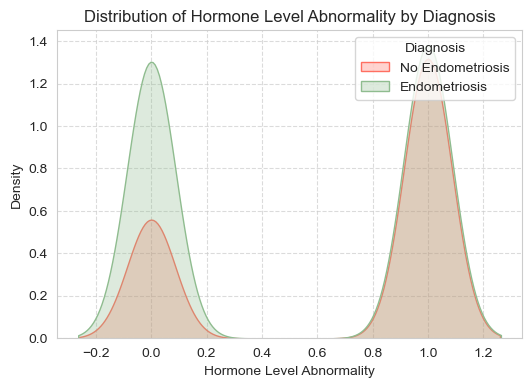

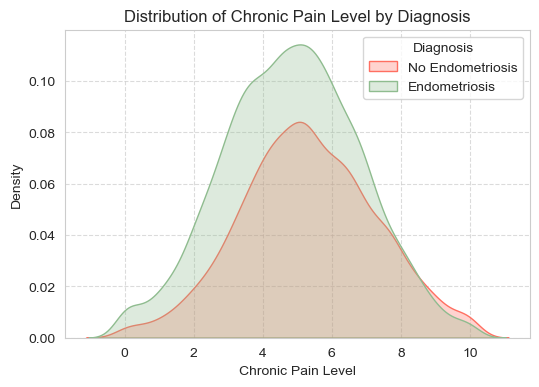

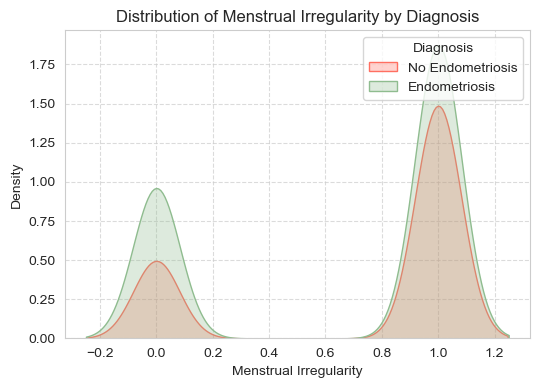

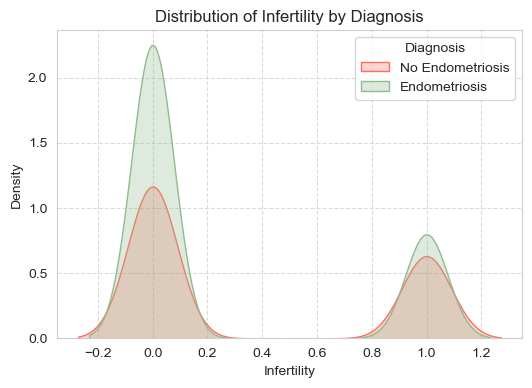

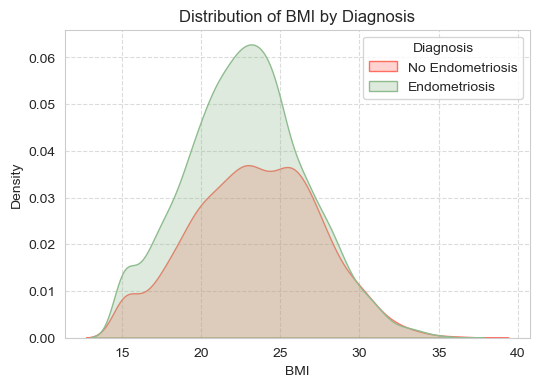

In [22]:
# Defining the features that showed some level of relation to diagnosis in statistical tests.
# These features will be visualized to check their distribution across diagnosed and undiagnosed cases.
features = ['Hormone_Level_Abnormality', 
            'Chronic_Pain_Level', 
            'Menstrual_Irregularity', 
            'Infertility', 
            'BMI']

# Dictionary mapping feature names to plot titles for better readability.
titles = {
    'Hormone_Level_Abnormality': 'Distribution of Hormone Level Abnormality by Diagnosis',
    'Chronic_Pain_Level': 'Distribution of Chronic Pain Level by Diagnosis',
    'Menstrual_Irregularity': 'Distribution of Menstrual Irregularity by Diagnosis',
    'Infertility': 'Distribution of Infertility by Diagnosis',
    'BMI': 'Distribution of BMI by Diagnosis'
}

# Generating KDE plots to compare feature distributions between diagnosed and undiagnosed cases.
for feature in features:
    plt.figure(figsize=(6,4))  # Set figure size for readability
    
    # KDE plot: Shows smoothed distribution of feature values for each diagnosis group.
    sns.kdeplot(
        data=df, 
        x=feature,  # Feature being plotted
        hue='Diagnosis',  # Color coding based on diagnosis (0 = No Endometriosis, 1 = Endometriosis)
        alpha=0.3,  # Transparency for better visualization
        palette=['#8FBC8F', '#FF6F61'],  # Custom colors for the two groups
        fill=True  # Fills the density curves for better comparison
    )
    
    # Adding title, labels, and grid for better readability
    plt.title(titles[feature])
    plt.xlabel(feature.replace('_', ' '))  # Replace underscores for cleaner labels
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', alpha=0.7)  # Add a subtle dashed grid
    
    # Custom legend labeling for clarity
    plt.legend(title='Diagnosis', labels=['No Endometriosis', 'Endometriosis'])
    
    # Show the plot
    plt.show()

### Interpretation of KDE Plots

These density plots illustrate the distribution of key numerical features across both diagnosed and undiagnosed individuals.

- **Hormone Level Abnormality**: This feature shows a distinct bimodal distribution, with diagnosed individuals predominantly falling in the abnormal category. The sharp separation suggests that this is one of the strongest predictors of endometriosis.
- **Chronic Pain Level**: While the distributions overlap, individuals with endometriosis generally report higher chronic pain levels. This suggests that while pain severity is a relevant feature, it alone may not be sufficient for diagnosis.
- **Menstrual Irregularity**: A strong separation is observed between diagnosed and undiagnosed individuals, with those diagnosed being more likely to experience irregular menstruation. This reinforces its importance as a predictive feature.
- **Infertility**: Similar to menstrual irregularity, infertility shows a significant difference between the two groups, indicating that it is a strong predictor of endometriosis.
- **BMI**: The distributions are similar, with a slight shift towards higher BMI values in diagnosed individuals. However, this difference is less pronounced, suggesting BMI may be a weaker predictor compared to the other features.

#### Key Takeaways:
- Hormone level abnormality, infertility, and menstrual irregularity appear to be the most distinct predictors of endometriosis.
- Chronic pain level is also relevant, but with more overlap between groups.
- BMI has the weakest distinction, meaning it may contribute less to prediction models.

## Chi-Square Test for Categorical Features

The Chi-Square test is used to assess whether there is a significant association between categorical features and the diagnosis of endometriosis. Unlike the t-test, which is applied to numerical features, the Chi-Square test evaluates whether the distribution of categorical variables differs significantly between diagnosed and undiagnosed individuals.

### Why Use the Chi-Square Test?
- It helps determine if features like **hormone level abnormality, menstrual irregularity, and infertility** are significantly associated with the diagnosis.
- If the p-value is **less than 0.05**, we reject the null hypothesis, meaning there is a significant relationship between the feature and the diagnosis.
- A higher Chi-Square statistic indicates a stronger association between the feature and the diagnosis.

In [23]:
# Function to perform the Chi-Square test for a given categorical feature.
# It tests whether the feature is significantly associated with the diagnosis.
def chi_square_test(data, feature, target='Diagnosis'):
    # Create a contingency table between the feature and the target variable.
    contingency_table = pd.crosstab(data[feature], data[target])
    
    # Perform the Chi-Square test.
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    # Determine whether the result is statistically significant (p < 0.05).
    significance = 'Yes' if p < 0.05 else 'No'
    
    # Store the results in a Series for easy conversion to a DataFrame later.
    return pd.Series({'Feature': feature, 'Chi2': chi2, 'P-Value': p, 'Significant': significance})

# Define the categorical features to be tested.
features = ['Hormone_Level_Abnormality', 'Menstrual_Irregularity', 'Infertility']

# Apply the Chi-Square test to each feature and collect results in a DataFrame.
chi_results = pd.DataFrame([chi_square_test(df, feature) for feature in features])

# Display the results to see which features are significantly associated with diagnosis.
display(chi_results)

,Feature,Chi2,P-Value,Significant
0,Hormone_Level_Abnormality,349.061731,6.783623e-78,Yes
1,Menstrual_Irregularity,90.203020,2.149338e-21,Yes
2,Infertility,92.062953,8.396255e-22,Yes


### Chi-Square Test Results Interpretation

The Chi-Square test evaluates the relationship between categorical features and the diagnosis of endometriosis. A high Chi-Square value and a **p-value below 0.05** indicate a significant association between the feature and diagnosis.

#### Key Observations:
- **Hormone Level Abnormality** has the strongest association with endometriosis (**Chi2 = 349.06, p < 0.00001**). This suggests that individuals with hormone level abnormalities are significantly more likely to be diagnosed with endometriosis.
- **Menstrual Irregularity** (**Chi2 = 90.20, p < 0.00001**) and **Infertility** (**Chi2 = 92.06, p < 0.00001**) also show strong associations with the diagnosis. Both features have highly significant p-values, confirming that these conditions are more prevalent among diagnosed individuals.

#### Implications:
- Since all tested features have **very low p-values**, they are strong candidates for inclusion in predictive modeling.
- **Hormone Level Abnormality** stands out as the most influential categorical feature in relation to endometriosis.
- These results align with medical literature, reinforcing the importance of hormonal factors, menstrual irregularities, and infertility in endometriosis diagnosis.

Further analysis can explore how these categorical features interact with continuous variables and assess their combined predictive power in machine learning models.

# Feature Engineering

To improve model interpretability and explore deeper relationships between symptoms, I created new categorical and interaction features:

1. **Chronic Pain Grouping**:  
   - Chronic pain levels were categorized into three groups: **Low (1-3), Mild (4-7), and High (8-10)**.
   - This allows for a clearer comparison of pain severity across diagnosed and undiagnosed patients.

2. **Interaction Features**:  
   - **Menstrual Irregularity + Hormone Abnormality vs. Diagnosis**:  
     - This explores how the combination of these factors affects endometriosis diagnosis likelihood.  
   - **Chronic Pain Group + Hormone Abnormality vs. Diagnosis**:  
     - This examines whether hormone level abnormalities affect diagnosis rates across different pain severity groups.

In [24]:
# --- Chronic Pain Grouping ---
# Creating a new categorical feature for chronic pain severity
df['Chronic_Pain_Group'] = pd.cut(
    df['Chronic_Pain_Level'],  # Target column
    bins=[-0.1, 3, 7, 10],  # Defining cutoff points for low, mild, and high pain
    labels=['Low', 'Mild', 'High'],  # Assigning category names
    right=True  # Ensures upper boundary is included in the category
)

# Display distribution of pain groups to check the categorization
display(df['Chronic_Pain_Group'].value_counts())

# --- Interaction Analysis: Multi-variable relationships ---
# Examining how menstrual irregularity + hormone abnormality impact diagnosis rates
interaction_1 = df.groupby(['Menstrual_Irregularity', 'Hormone_Level_Abnormality'])['Diagnosis'].mean().reset_index()
display(interaction_1)

# Examining how chronic pain severity + hormone abnormality influence diagnosis rates
interaction_2 = df.groupby(['Chronic_Pain_Group', 'Hormone_Level_Abnormality'])['Diagnosis'].mean().reset_index()
display(interaction_2)

Chronic_Pain_Group
Mild    6848
High    1631
Low     1521
Name: count, dtype: int64

,Menstrual_Irregularity,Hormone_Level_Abnormality,Diagnosis
0,0,0,0.237008
1,0,1,0.409117
2,1,0,0.324583
3,1,1,0.516121


,Chronic_Pain_Group,Hormone_Level_Abnormality,Diagnosis
0,Low,0,0.191456
1,Low,1,0.382452
2,Mild,0,0.301136
3,Mild,1,0.485367
4,High,0,0.385335
5,High,1,0.571717


### Interpretation of Feature Engineering Results

#### Chronic Pain Grouping
- Most patients fall into the **Mild pain** category (6,848 cases), followed by **High pain** (1,631 cases) and **Low pain** (1,521 cases).
- Categorizing pain levels helps us analyze trends more effectively instead of treating pain as a continuous variable.

#### Interaction 1: Menstrual Irregularity + Hormone Abnormality vs. Diagnosis
- **Patients with both menstrual irregularity and hormone abnormalities have the highest likelihood of diagnosis (~51.6%)**.
- Those with **neither condition** show the lowest diagnosis rate (~23.7%).
- Having just one condition moderately increases the likelihood of an endometriosis diagnosis.

#### Interaction 2: Chronic Pain Group + Hormone Abnormality vs. Diagnosis
- **Patients in the "High" pain group with hormone abnormalities** have the highest diagnosis rate (~57.1%).
- Those with **low pain and no hormone abnormality** have the lowest (~19.1%).
- **Hormone level abnormality seems to have a strong impact across all pain levels**.

#### Key Takeaways:
- **Both menstrual irregularity and hormone abnormalities are strong indicators** of diagnosis probability.
- **Chronic pain severity also influences diagnosis**, but its impact is strongest when combined with hormone level abnormalities.
- These engineered features provide **valuable insights for model training** and could enhance predictive performance.

## Feature Engineering: Additional Derived Features

1. **Age Grouping**:  
   - Patients were categorized into **four age groups** based on reproductive stages:  
     - 18-25  
     - 26-35  
     - 36-45  
     - 46-50  

2. **BMI Categories**:  
   - Patients were categorized into **WHO standard BMI groups**:  
     - Underweight (BMI < 18.5)  
     - Normal (BMI 18.5 - 24.9)  
     - Overweight (BMI 25 - 29.9)  
     - Obese (BMI ≥ 30)  

3. **Symptom Score**:  
   - A **composite score summing up positive symptoms** (Menstrual Irregularity, Hormone Abnormality, Infertility) to quantify symptom severity.

4. **Symptom Interactions**:  
   - **Hormone-Menstrual Interaction**: Captures combined effects of hormone abnormalities and menstrual irregularity.  
   - **Pain-Hormone Interaction**: Evaluates how chronic pain severity relates to hormone abnormalities.  
   - **Pain-Infertility Interaction**: Explores the relationship between pain intensity and infertility.  

These engineered features could provide **additional predictive power for classification models** and help identify **hidden patterns in symptom relationships**.

In [25]:
# --- Feature Engineering: Creating New Predictive Features ---

# 1. Age Grouping (based on reproductive stages)
# This groups patients into key reproductive stages to see if age plays a role in diagnosis likelihood.
df['Age_Group'] = pd.cut(df['Age'], 
                         bins=[17, 25, 35, 45, 50],  # Defined age brackets
                         labels=['18-25', '26-35', '36-45', '46-50'],  # Category labels
                         right=True)  # Include the upper boundary in the range

# 2. BMI Categories (WHO Classification)
# Categorizing BMI into standard weight classifications helps examine weight-related risk factors.
df['BMI_Category'] = pd.cut(df['BMI'], 
                            bins=[0, 18.5, 24.9, 29.9, 40],  # WHO standard BMI ranges
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'],  # Category labels
                            right=True)

# 3. Symptom Score (Total count of positive symptoms)
# This sums up major symptoms (Menstrual Irregularity, Hormone Abnormality, Infertility) to assess severity.
df['Symptom_Score'] = (df['Menstrual_Irregularity'] + 
                       df['Hormone_Level_Abnormality'] + 
                       df['Infertility']).astype(int)  # Ensure integer values

# 4. Symptom Interactions (Key interactions between symptoms)
# Captures combined effects of hormonal and menstrual abnormalities.
df['Hormone_Menstrual_Interaction'] = (df['Hormone_Level_Abnormality'] * 
                                       df['Menstrual_Irregularity']).astype(int)

# Examines the relationship between chronic pain severity and hormone imbalances.
df['Pain_Hormone_Interaction'] = (df['Chronic_Pain_Level'] * 
                                  df['Hormone_Level_Abnormality']).astype(int)

# Investigates the link between pain intensity and infertility.
df['Pain_Infertility_Interaction'] = (df['Chronic_Pain_Level'] * 
                                      df['Infertility']).astype(int)

# --- Save the updated dataset ---
# The dataset is saved with new engineered features to be used for further analysis and modeling.
df.to_csv('endometriosis_dataset_with_features.csv', index=False)

# --- Preview the new columns ---
# Display a preview of the newly added features to ensure they are correctly created.
print("New Columns Preview:")
print(df[['Age_Group', 'BMI_Category', 'Symptom_Score', 
          'Hormone_Menstrual_Interaction', 
          'Pain_Hormone_Interaction', 
          'Pain_Infertility_Interaction']].head())

New Columns Preview:
  Age_Group BMI_Category  Symptom_Score  Hormone_Menstrual_Interaction  \
0     18-25       Normal              1                              0   
1     36-45       Normal              1                              0   
2     46-50       Normal              2                              1   
3     26-35       Normal              1                              0   
4     26-35       Normal              2                              1   

   Pain_Hormone_Interaction  Pain_Infertility_Interaction  
0                         0                             0  
1                         0                             0  
2                         3                             0  
3                         0                             0  
4                         3                             0  


## Interpretation of Engineered Features

### Age Grouping:
- Patients are now categorized into **four reproductive stages**, helping assess whether **age influences diagnosis risk**.
- This may provide insights into **early vs. late onset of endometriosis symptoms**.

### BMI Categories:
- Dividing BMI into **standard WHO categories** allows us to check if **weight influences diagnosis likelihood**.
- If certain BMI groups have higher rates of endometriosis, this could be a risk factor.

### Symptom Score:
- By summing up key symptoms (Menstrual Irregularity, Hormone Abnormality, Infertility), we created a **severity score**.
- Higher scores **might correlate with higher diagnosis likelihood**, making this feature useful for prediction.

### Interaction Features:
- **Hormone-Menstrual Interaction**:  
  - Patients with **both abnormalities** may have a significantly higher risk.  
- **Pain-Hormone Interaction**:  
  - Helps determine whether **pain severity amplifies hormonal effects**.  
- **Pain-Infertility Interaction**:  
  - Examines whether **higher pain levels are associated with infertility**, which is a key symptom of endometriosis.

### Key Takeaways:
- These engineered features may **improve model performance** by capturing **hidden relationships between symptoms**.
- They provide **new ways to interpret the dataset**, making predictions more **clinically relevant**.
- The next step is to **analyze these features and determine their actual predictive power**.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Age                            10000 non-null  int64   
 1   Menstrual_Irregularity         10000 non-null  int64   
 2   Chronic_Pain_Level             10000 non-null  float64 
 3   Hormone_Level_Abnormality      10000 non-null  int64   
 4   Infertility                    10000 non-null  int64   
 5   BMI                            10000 non-null  float64 
 6   Diagnosis                      10000 non-null  int64   
 7   Chronic_Pain_Group             10000 non-null  category
 8   Age_Group                      10000 non-null  category
 9   BMI_Category                   10000 non-null  category
 10  Symptom_Score                  10000 non-null  int32   
 11  Hormone_Menstrual_Interaction  10000 non-null  int32   
 12  Pain_Hormone_Interaction       10

# Feature Selection


To improve model performance and reduce noise, I need to select the most relevant features. This process includes:

1. **Removing Highly Correlated Features:** Features that are strongly correlated (above 0.85) provide redundant information. I will remove one feature from each correlated pair.
2. **Assessing Feature Importance:** Using **Mutual Information (MI)** and **Random Forest Feature Importance** to identify the most influential variables.
3. **Applying Recursive Feature Elimination (RFE):** Selecting top features using Logistic Regression to refine the feature set further.

This ensures that the dataset is optimized for training, improving interpretability and effciency.


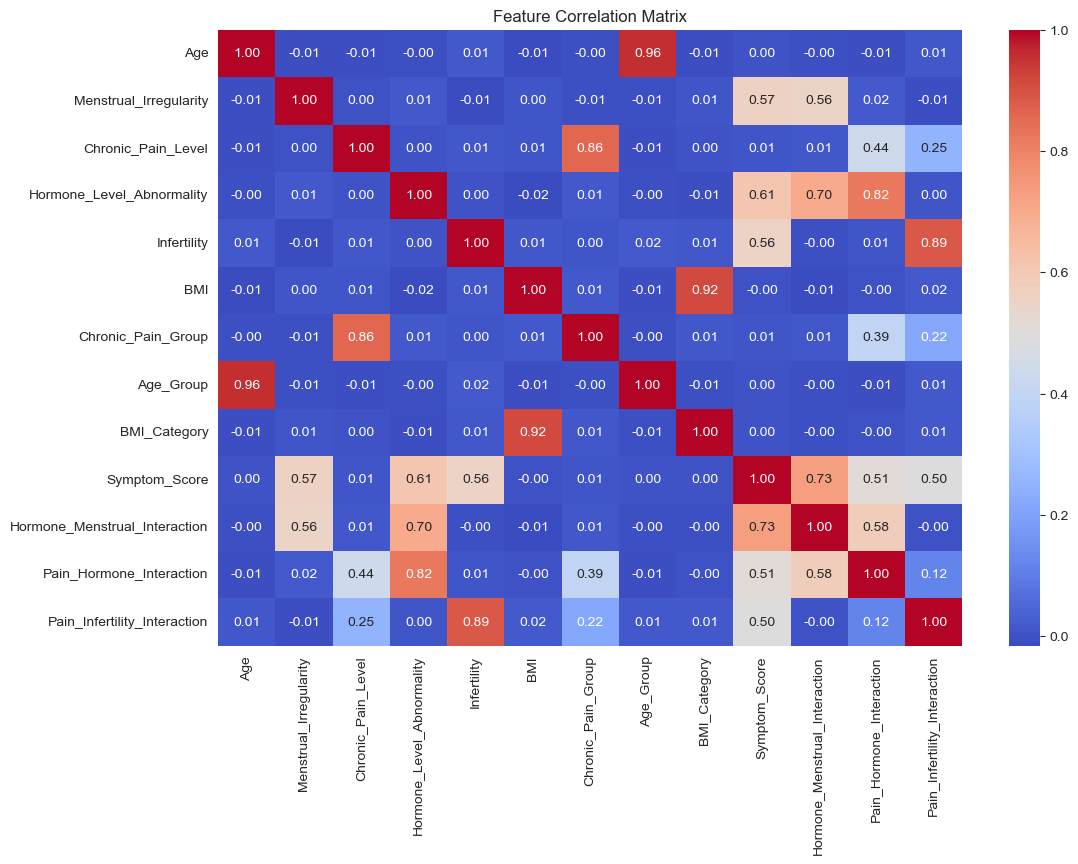


Highly Correlated Features (Above 0.85):
Age - Age_Group: 0.957882198305486
Age_Group - Age: 0.957882198305486
BMI - BMI_Category: 0.9151392528567237
BMI_Category - BMI: 0.9151392528567237
Infertility - Pain_Infertility_Interaction: 0.8887218891034465
Pain_Infertility_Interaction - Infertility: 0.8887218891034465
Chronic_Pain_Group - Chronic_Pain_Level: 0.8606686182914594
Chronic_Pain_Level - Chronic_Pain_Group: 0.8606686182914594

Dropped Features Due to High Correlation: {'BMI', 'Chronic_Pain_Group', 'BMI_Category', 'Age', 'Pain_Infertility_Interaction', 'Age_Group', 'Chronic_Pain_Level', 'Infertility'}

Mutual Information Scores:
Symptom_Score                    0.024584
Hormone_Menstrual_Interaction    0.022363
Pain_Hormone_Interaction         0.018747
Hormone_Level_Abnormality        0.016666
Menstrual_Irregularity           0.000000
dtype: float64


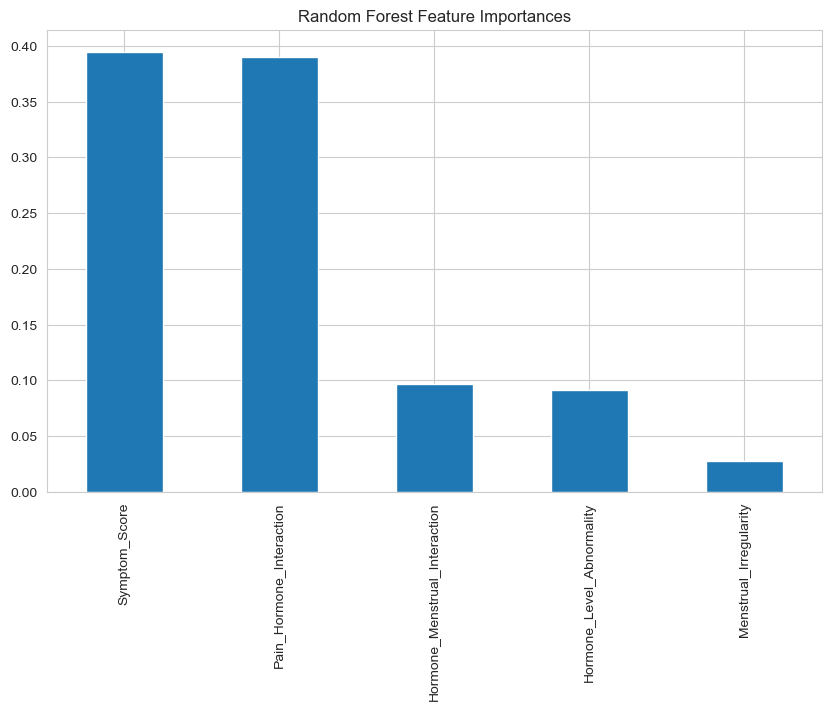


Top 10 Important Features (Random Forest):
Symptom_Score                    0.394684
Pain_Hormone_Interaction         0.389824
Hormone_Menstrual_Interaction    0.096860
Hormone_Level_Abnormality        0.091111
Menstrual_Irregularity           0.027521
dtype: float64

Selected Features from RFE:
Index(['Menstrual_Irregularity', 'Hormone_Level_Abnormality', 'Symptom_Score',
       'Hormone_Menstrual_Interaction', 'Pain_Hormone_Interaction'],
      dtype='object')

Final Selected Features for Modeling:
['Pain_Hormone_Interaction', 'Hormone_Level_Abnormality', 'Symptom_Score', 'Hormone_Menstrual_Interaction', 'Menstrual_Irregularity']

Final dataset saved as 'endometriosis_dataset_final.csv'


In [29]:
# --- Step 1: Define Features and Target ---
# Removing the target variable from the dataset
X = df.drop(columns=['Diagnosis'])  # Features only
y = df['Diagnosis']                 # Target variable (Endometriosis diagnosis)

# --- Step 2: Convert Categorical to Numerical ---
# Encoding categorical variables so they can be used in correlation analysis
for col in X.select_dtypes(include=['category', 'object']).columns:
    X[col] = X[col].astype('category').cat.codes  # Assign numerical codes

# --- Step 3: Correlation Analysis ---
# Compute the correlation matrix to find relationships between features
corr_matrix = X.corr(numeric_only=True)

# Visualizing the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

# Finding pairs of highly correlated features (above threshold)
threshold = 0.85
corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = [(f1, f2) for f1, f2 in corr_pairs.index if f1 != f2 and corr_pairs[f1, f2] > threshold]

# Print highly correlated feature pairs
print("\nHighly Correlated Features (Above 0.85):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {corr_pairs[pair]}")

# Remove one feature from each correlated pair to avoid redundancy
high_corr_features = set([pair[1] for pair in high_corr_pairs])
X = X.drop(columns=high_corr_features)
print("\nDropped Features Due to High Correlation:", high_corr_features)

# --- Step 4: Mutual Information Analysis ---
# Calculate mutual information scores to assess feature relevance
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("\nMutual Information Scores:")
print(mi_scores)

# --- Step 5: Random Forest Feature Importance ---
# Training a Random Forest model to rank feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 6))
rf_importances.plot(kind='bar')
plt.title('Random Forest Feature Importances')
plt.show()

print("\nTop 10 Important Features (Random Forest):")
print(rf_importances.head(10))

# --- Step 6: Recursive Feature Elimination (RFE) ---
# Using Logistic Regression for feature selection
logreg = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=logreg, n_features_to_select=10)  # Selecting top 10 features
rfe.fit(X, y)

rfe_features = X.columns[rfe.support_]
print("\nSelected Features from RFE:")
print(rfe_features)

# --- Step 7: Final Feature Selection ---
# Combining top features from RFE, Mutual Information, and Random Forest
selected_features = list(set(rfe_features) | set(rf_importances.head(10).index) | set(mi_scores.head(10).index))
X = X[selected_features]

print("\nFinal Selected Features for Modeling:")
print(selected_features)

# --- Step 8: Save Final Dataset ---
df[selected_features + ['Diagnosis']].to_csv('endometriosis_dataset_final.csv', index=False)
print("\nFinal dataset saved as 'endometriosis_dataset_final.csv'")


## Interpretation of Feature Selection Results

1. **Correlation Analysis:**
   - Highly correlated features were removed to prevent redundancy. For example, `Age` and `Age_Group`, and `BMI` and `BMI_Category` were strongly correlated.
   - Removing one feature from each correlated pair helps avoid multicollinearity issues.

2. **Mutual Information Scores:**
   - `Symptom_Score`, `Hormone_Menstrual_Interaction`, and `Pain_Hormone_Interaction` were among the most relevant predictors of endometriosis.

3. **Random Forest Feature Importance:**
   - Random Forest identified **Symptom_Score** and **Pain_Hormone_Interaction** as the strongest predictors.

4. **Recursive Feature Elimination (RFE):**
   - RFE selected features such as **Menstrual Irregularity, Hormone Level Abnormality, and Symptom Score**, confirming their relevance.

## Final Outcome:
The final dataset includes a refined set of features that contribute the most to predicting endometriosis. This selection ensures the model is both interpretable and efficient.

# Baseline Model Training

## Splitting the Dataset for Training, Validation, and Testing

Before training the baseline model, I need to split the dataset into training, validation, and test sets. Proper data splitting ensures that the model generalizes well and prevents overfitting.

### Considerations for Splitting:
1. **Dataset Size (10K Entries)**
   - With a medium-sized dataset, a larger training set improves learning.
   - A too-small test set may lead to unreliable final evaluation.
   - A too-small validation set may not allow for proper hyperparameter tuning.

2. **Model Complexity**
   - Simpler models (e.g., Logistic Regression) require less training data.
   - More complex models (e.g., Deep Learning) benefit from larger training sets.

3. **Class Balance (Stratification Needed)**
   - Endometriosis cases may be fewer than non-cases.
   - Stratified splitting ensures the class distribution remains balanced across subsets.

### Splitting Strategy:
- **Step 1:** Split into **train (80%)** and **test (20%)**.
- **Step 2:** Further split the training set into **train (75%)** and **validation (25%)**.
- **Final Ratios:**
  - **X_train (60%)** – Used to train the model.
  - **X_val (20%)** – Used to validate and tune the model.
  - **X_test (20%)** – Used for final evaluation.

This structured approach ensures reliable evaluation and tuning while keeping the class distribution balanced.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, 
                                                  stratify=y_train, 
                                                  random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (6000, 5), Validation set: (2000, 5), Test set: (2000, 5)


## Training Multiple Models on Imbalanced Data

In this section, I train and evaluate three different machine learning models on the imbalanced dataset to establish a baseline performance. This will help identify how well each model performs without applying any techniques to address class imbalance.

### Why Train Multiple Models?
- **Logistic Regression:** A simple and interpretable linear model that serves as a benchmark.
- **Random Forest:** A tree-based ensemble model that captures non-linear relationships.
- **XGBoost:** A gradient boosting model known for handling class imbalance effectively.

### Evaluation Metrics:
To assess model performance, I use:
- **Accuracy:** Measures overall correctness but can be misleading with imbalanced data.
- **Precision:** Indicates how many predicted endometriosis cases are truly positive.
- **Recall:** Shows how many actual endometriosis cases were correctly identified.
- **F1-score:** A balance between precision and recall, especially useful for imbalanced datasets.

Each model's predictions are analyzed using classification reports and confusion matrices.



Training Logistic Regression...

Validation Set Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.64      0.83      0.72      1184
           1       0.57      0.32      0.41       816

    accuracy                           0.62      2000
   macro avg       0.61      0.58      0.57      2000
weighted avg       0.61      0.62      0.60      2000



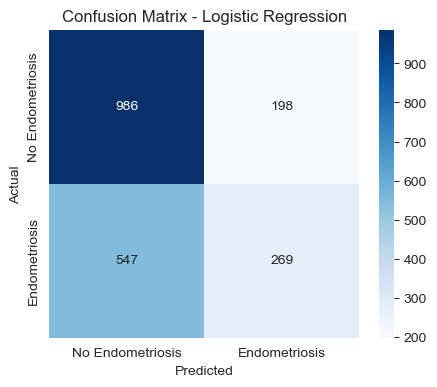


Training Random Forest...

Validation Set Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.64      0.78      0.70      1184
           1       0.54      0.37      0.44       816

    accuracy                           0.61      2000
   macro avg       0.59      0.57      0.57      2000
weighted avg       0.60      0.61      0.60      2000



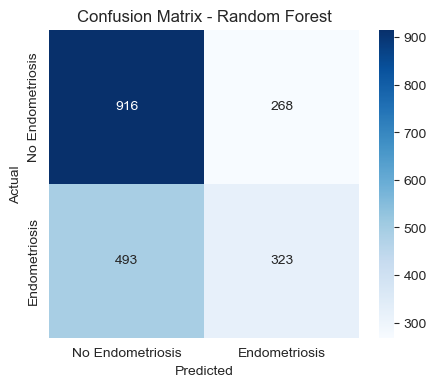


Training XGBoost...

Validation Set Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.64      0.78      0.70      1184
           1       0.54      0.37      0.44       816

    accuracy                           0.61      2000
   macro avg       0.59      0.57      0.57      2000
weighted avg       0.60      0.61      0.60      2000



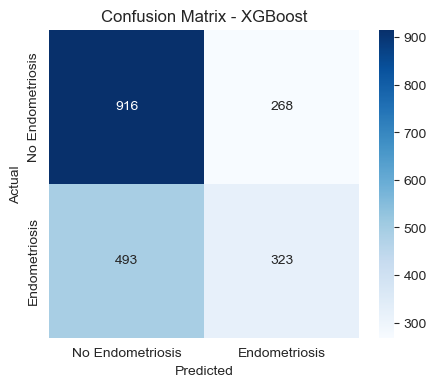


Model Performance Comparison:


,Model,Val Accuracy,Val Precision,Val Recall,Val F1-score,Test Accuracy,Test Precision,Test Recall,Test F1-score
0,Logistic Regression,0.6245,0.570499,0.322304,0.411903,0.6275,0.576017,0.329657,0.419330
1,Random Forest,0.6120,0.535336,0.371324,0.438495,0.6195,0.546531,0.395833,0.459133
2,XGBoost,0.6120,0.535336,0.371324,0.438495,0.6195,0.546531,0.395833,0.459133


In [31]:
# --- Step 1: Define Models for Training ---
# Three models are selected to compare their baseline performance.
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# List to store evaluation metrics for comparison
results = []

# --- Step 2: Train and Evaluate Each Model ---
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")  # Indicate model training start
    
    # Train the model on the training set
    model.fit(X_train, y_train)
    
    # Make predictions on validation and test sets
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Compute validation set performance metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)

    # Compute test set performance metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    # Store performance metrics for comparison
    results.append({
        "Model": model_name,
        "Val Accuracy": val_accuracy, "Val Precision": val_precision, "Val Recall": val_recall, "Val F1-score": val_f1,
        "Test Accuracy": test_accuracy, "Test Precision": test_precision, "Test Recall": test_recall, "Test F1-score": test_f1
    })

    # Print classification report for validation set
    print(f"\nValidation Set Classification Report for {model_name}:")
    print(classification_report(y_val, y_val_pred))

    # --- Step 3: Generate Confusion Matrix ---
    # Create a confusion matrix to visualize classification performance
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["No Endometriosis", "Endometriosis"], 
                yticklabels=["No Endometriosis", "Endometriosis"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# --- Step 4: Compare Model Performance ---
# Convert results into a DataFrame for easy comparison
results_df = pd.DataFrame(results)

# Display the final comparison table
print("\nModel Performance Comparison:")
display(results_df)

## Model Performance Analysis

### Logistic Regression:
- **Validation Accuracy:** 62.5%
- **Validation Recall:** 32.2% - Low recall means it struggles to detect endometriosis cases.
- **Validation F1-score:** 41.2% - Poor balance of precision and recall.
- **Confusion Matrix:** Shows a high number of false negatives, meaning many endometriosis cases go undetected.

### Random Forest:
- **Validation Accuracy:** 61.2%
- **Validation Recall:** 37.1% - Slightly better at detecting endometriosis cases.
- **Validation F1-score:** 43.8% - Improved over Logistic Regression.
- **Confusion Matrix:** Detects more endometriosis cases but still has many false negatives.

### XGBoost:
- **Validation Accuracy:** 61.2%
- **Validation Recall:** 37.1% - Same as Random Forest.
- **Validation F1-score:** 43.8% - Matches Random Forest.
- **Confusion Matrix:** Almost identical to Random Forest.

### Key Observations:
1. **Overall accuracy is similar across all models (~61-62%),** but accuracy alone is not sufficient due to class imbalance.
2. **Recall (ability to identify endometriosis cases) is low for all models,** meaning a large number of endometriosis cases are missed.
3. **Random Forest and XGBoost outperform Logistic Regression in recall and F1-score.**
4. **The models still struggle with class imbalance,** requiring further improvement through techniques like resampling or weighted loss functions.

### Next Steps:
Since recall is crucial for medical diagnosis, I will explore ways to improve model performance, such as:
- Handling class imbalance with **oversampling (SMOTE) or undersampling.**
- **Hyperparameter tuning** to optimize model performance.
- Experimenting with **different algorithms** beyond these three models.

## Class Balancing

In this section, I implement class balancing techniques to improve model performance, particularly recall, which is critical for detecting endometriosis cases. Instead of modifying the dataset itself, I adjust how the models treat each class.

### Why Address Class Imbalance?
- **Unbalanced datasets can bias models** toward predicting the majority class (no endometriosis), leading to poor recall.
- **A high number of false negatives is problematic** in a medical setting, as undiagnosed cases can have serious consequences.

### Class Weighting: The First Approach
Instead of altering the dataset, class weighting modifies how the model treats different classes.
- **Logistic Regression & Random Forest**: Use `class_weight="balanced"`, which automatically adjusts weights based on class distribution.
- **XGBoost**: Uses `scale_pos_weight`, calculated as the ratio of the majority class to the minority class.

For this dataset:
\[
\text{scale_pos_weight} = \frac{\text{majority class count}}{\text{minority class count}} = \frac{1184}{816} = 1.45
\]

### Why Use Class Weighting First?
- **Preserves real-world class distribution** (avoids artificial data).
- **Works well for mild-to-moderate imbalance (like 41%-59%)**.
- **Lower risk of overfitting** compared to synthetic sampling techniques.
- **Efficient and easy to implement** in models that support it.

### When to Consider SMOTE?
If class weighting does not sufficiently improve recall, I will explore Synthetic Minority Oversampling Technique (SMOTE), which generates synthetic minority class examples. However, SMOTE:
- **Can introduce noise** by creating synthetic cases that may not reflect real-world patterns.
- **Is more useful for extreme imbalance** (e.g., 90%-10%), which is not the case here.
- **Requires careful tuning** to avoid overfitting.

For now, I will proceed with class weighting and assess its impact on model performance before considering SMOTE.



Training Logistic Regression with Class Weighting...

Validation Set Classification Report for Logistic Regression with Class Weighting:
              precision    recall  f1-score   support

           0       0.68      0.60      0.64      1184
           1       0.50      0.59      0.54       816

    accuracy                           0.60      2000
   macro avg       0.59      0.60      0.59      2000
weighted avg       0.61      0.60      0.60      2000



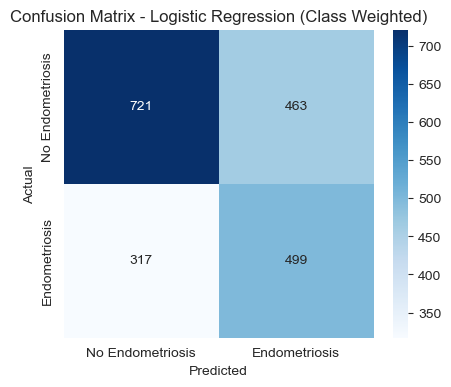


Training Random Forest with Class Weighting...

Validation Set Classification Report for Random Forest with Class Weighting:
              precision    recall  f1-score   support

           0       0.70      0.53      0.60      1184
           1       0.50      0.67      0.57       816

    accuracy                           0.59      2000
   macro avg       0.60      0.60      0.59      2000
weighted avg       0.62      0.59      0.59      2000



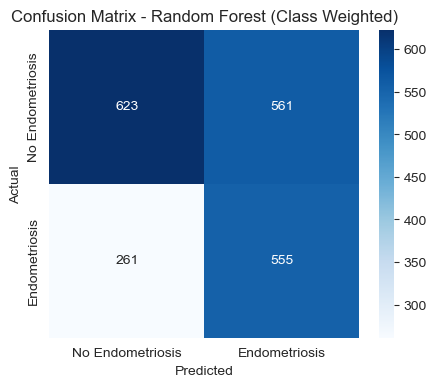


Training XGBoost with Class Weighting...

Validation Set Classification Report for XGBoost with Class Weighting:
              precision    recall  f1-score   support

           0       0.70      0.53      0.60      1184
           1       0.50      0.67      0.57       816

    accuracy                           0.59      2000
   macro avg       0.60      0.60      0.59      2000
weighted avg       0.62      0.59      0.59      2000



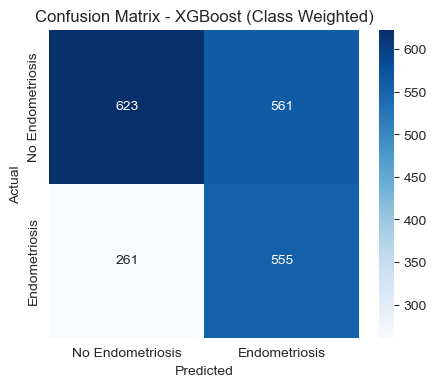


Model Performance Comparison After Class Weighting:


,Model,Val Accuracy,Val Precision,Val Recall,Val F1-score,Test Accuracy,Test Precision,Test Recall,Test F1-score
0,Logistic Regression,0.596,0.504175,0.591912,0.544532,0.610,0.518711,0.611520,0.561305
1,Random Forest,0.587,0.495487,0.672794,0.570686,0.589,0.497312,0.680147,0.574534
2,XGBoost,0.587,0.495487,0.672794,0.570686,0.589,0.497312,0.680147,0.574534


In [32]:
# --- Step 2: Apply Class Weighting ---

# Calculate the weight ratio for XGBoost based on the class distribution
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Define models with class weighting adjustments
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42)
}

# Initialize results storage
results = []

for model_name, model in models.items():
    print(f"\nTraining {model_name} with Class Weighting...")

    # Train the model using the training data
    model.fit(X_train, y_train)

    # Predict outcomes for validation and test sets
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Evaluate model performance
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    # Store evaluation metrics
    results.append({
        "Model": model_name,
        "Val Accuracy": val_accuracy, "Val Precision": val_precision, "Val Recall": val_recall, "Val F1-score": val_f1,
        "Test Accuracy": test_accuracy, "Test Precision": test_precision, "Test Recall": test_recall, "Test F1-score": test_f1
    })

    # Display classification report for validation data
    print(f"\nValidation Set Classification Report for {model_name} with Class Weighting:")
    print(classification_report(y_val, y_val_pred))

    # Generate a confusion matrix for test predictions
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Endometriosis", "Endometriosis"], yticklabels=["No Endometriosis", "Endometriosis"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name} (Class Weighted)')
    plt.show()

# --- Step 3: Compare Model Performance After Class Weighting ---

# Convert results into a DataFrame for comparison
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison After Class Weighting:")
display(results_df)

### Results After Applying Class Weighting

#### Key Observations
- **Recall improved significantly** across all models:
  - Logistic Regression: Recall increased from **32% → 59%**.
  - Random Forest & XGBoost: Recall increased from **~37% → 67%**.
  - This means the models are now detecting **more actual endometriosis cases**.
  
- **Accuracy & Precision dropped**:
  - Precision **decreased** for all models (**~57% → 50%**).
  - More **false positives** (incorrectly diagnosing non-endometriosis cases as positive).

#### Confusion Matrix Insights
- **Before Class Weighting**:
  - Too many **false negatives** (missed real endometriosis cases).
- **After Class Weighting**:
  - **False negatives reduced** significantly (models now detect more actual cases).
  - **False positives increased** (more non-cases wrongly diagnosed as endometriosis).

#### Key Takeaway
- **Class weighting helped recall but hurt precision**, making the models overly sensitive to predicting endometriosis.
- This is expected, as class weighting forces models to **prioritize the minority class**.

---

### Next Steps
Since class weighting improved recall but **reduced precision**, we need further fine-tuning. 

#### Two Possible Solutions:
1. **Threshold Tuning (Recommended First)**
   - Instead of using a default **0.5 threshold**, adjust it to balance precision and recall.
   - This is a lightweight approach that often works well after class weighting.

2. **SMOTE (If Needed)**
   - If threshold tuning **does not improve precision**, oversampling can be applied.
   - Since our imbalance is **41%-59%**, SMOTE may not be the best first choice.

**Next, we will explore threshold tuning to see if we can optimize precision without sacrificing recall.**

## Threshold Tuning


### Why Threshold Tuning?
After applying class weighting, **recall improved**, but **precision decreased**. To achieve a better balance between the two, we will adjust the classification threshold.
#### How It Works:
- By default, models use a **threshold of 0.5**, meaning:
  - If the predicted probability **≥ 0.5**, the model predicts **endometriosis (1)**.
  - If the predicted probability **< 0.5**, the model predicts **no endometriosis (0)**.

- In **imbalanced datasets**, this default threshold may not be optimal. Adjusting it allows us to control the trade-off between **precision and recall**:
  - **Lowering the threshold (e.g., 0.4)** → More cases predicted as endometriosis.
    - **Effect:** **Higher recall**, but **lower precision** (more false positives).
  - **Increasing the threshold (e.g., 0.6)** → Fewer cases predicted as endometriosis.
    - **Effect:** **Higher precision**, but **lower recall** (more false egatives).

#### Goal:
Find the **best threshold** that maintains a good balance between **recall (identifying real cases)** and **precision (minimizing fase positives)**.



Evaluating Threshold Tuning for Logistic Regression...


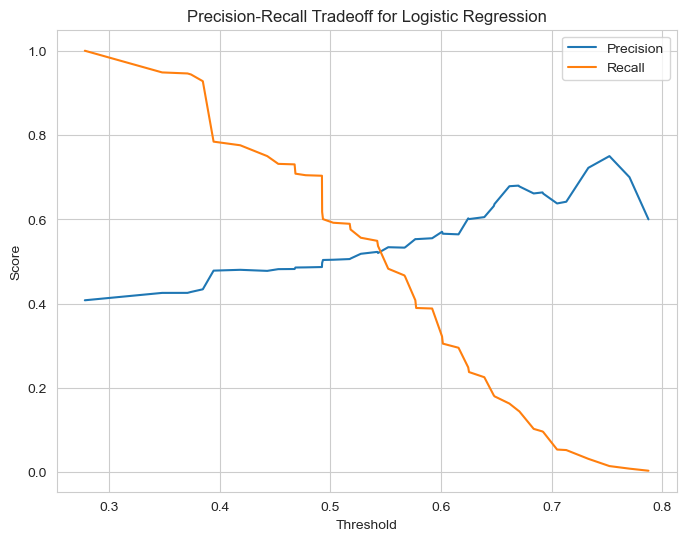

Best Threshold for Logistic Regression: 0.394

Evaluating Threshold Tuning for Random Forest...


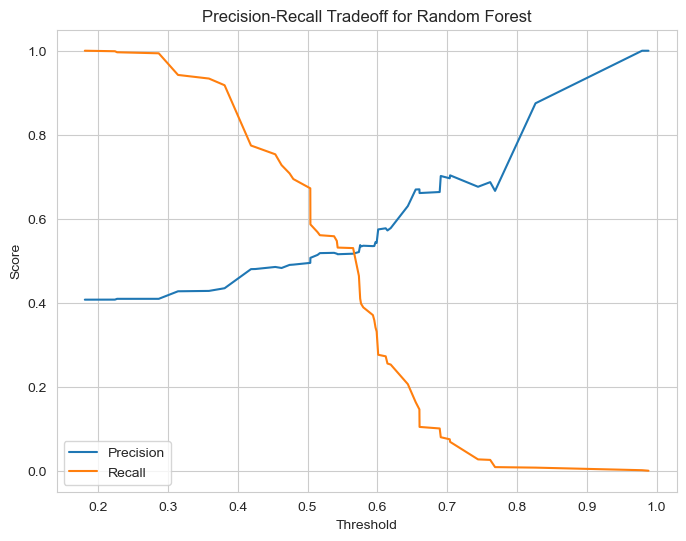

Best Threshold for Random Forest: 0.419

Evaluating Threshold Tuning for XGBoost...


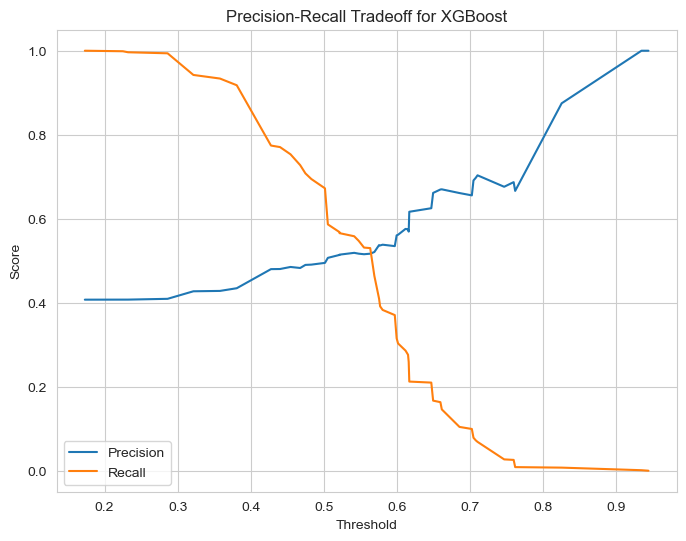

Best Threshold for XGBoost: 0.428

Applying Threshold 0.394 for Logistic Regression...

Validation Set Classification Report for Logistic Regression (Threshold = 0.394):
              precision    recall  f1-score   support

           0       0.73      0.41      0.53      1184
           1       0.48      0.78      0.59       816

    accuracy                           0.56      2000
   macro avg       0.61      0.60      0.56      2000
weighted avg       0.63      0.56      0.55      2000



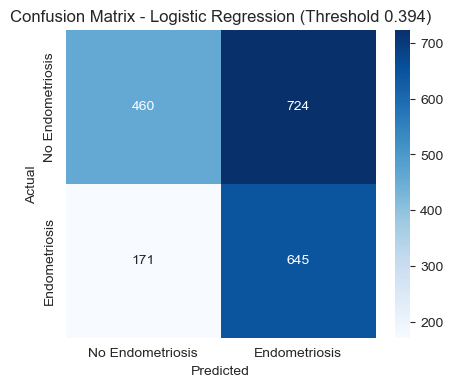


Applying Threshold 0.419 for Random Forest...

Validation Set Classification Report for Random Forest (Threshold = 0.419):
              precision    recall  f1-score   support

           0       0.73      0.42      0.54      1184
           1       0.48      0.77      0.59       816

    accuracy                           0.57      2000
   macro avg       0.61      0.60      0.56      2000
weighted avg       0.63      0.57      0.56      2000



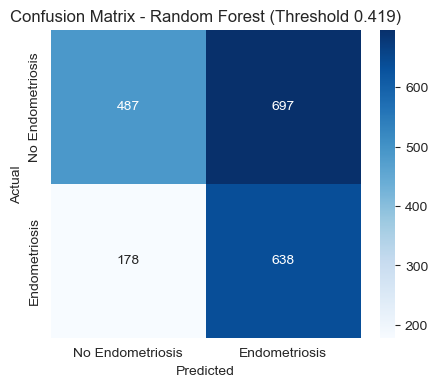


Applying Threshold 0.428 for XGBoost...

Validation Set Classification Report for XGBoost (Threshold = 0.428):
              precision    recall  f1-score   support

           0       0.73      0.42      0.54      1184
           1       0.48      0.77      0.59       816

    accuracy                           0.57      2000
   macro avg       0.61      0.60      0.56      2000
weighted avg       0.63      0.57      0.56      2000



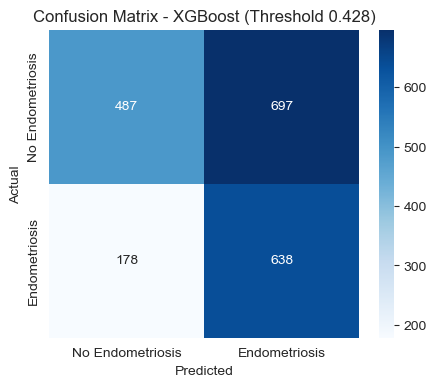


Model Performance Comparison After Threshold Tuning:


,Model,Val Accuracy,Val Precision,Val Recall,Val F1-score,Test Accuracy,Test Precision,Test Recall,Test F1-score
0,Logistic Regression,0.5630,0.478326,0.784314,0.594243,0.5525,0.471147,0.790441,0.590389
1,Random Forest,0.5665,0.480608,0.774510,0.593149,0.5625,0.477903,0.781863,0.593212
2,XGBoost,0.5665,0.480608,0.774510,0.593149,0.5625,0.477903,0.781863,0.593212


In [35]:
# Function to evaluate different threshold values for precision-recall tradeoff
# This helps visualize how the model behaves with different decision thresholds
def evaluate_thresholds(model, X_val, y_val, model_name):
    y_probs = model.predict_proba(X_val)[:, 1]  # Extract probability scores for the positive class

    # Compute precision-recall curve values
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs)
    
    # Plot Precision-Recall curve against thresholds
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[:-1], label="Precision")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Precision-Recall Tradeoff for {model_name}")
    plt.legend()
    plt.show()
    
    return precisions, recalls, thresholds, y_probs

# Function to determine the best threshold based on F1-score optimization
# F1-score balances precision and recall, making it useful for imbalanced datasets
def find_best_threshold(precisions, recalls, thresholds):
    f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-6)  # Compute F1-score for each threshold
    best_idx = np.argmax(f1_scores)  # Locate the index with the highest F1-score
    return thresholds[best_idx]

# Dictionary to store the best threshold for each model
best_thresholds = {}

# Iterate through each model to evaluate and determine optimal threshold
for model_name, model in models.items():
    print(f"\nEvaluating Threshold Tuning for {model_name}...")

    # Generate precision-recall curve and obtain probability scores
    precisions, recalls, thresholds, y_probs = evaluate_thresholds(model, X_val, y_val, model_name)

    # Identify best threshold based on F1-score
    best_thresh = find_best_threshold(precisions, recalls, thresholds)
    best_thresholds[model_name] = best_thresh
    print(f"Best Threshold for {model_name}: {best_thresh:.3f}")

# --- Apply the Best Thresholds and Evaluate Models ---
results = []

for model_name, model in models.items():
    print(f"\nApplying Threshold {best_thresholds[model_name]:.3f} for {model_name}...")

    # Predict probabilities on validation and test sets
    y_val_probs = model.predict_proba(X_val)[:, 1]
    y_test_probs = model.predict_proba(X_test)[:, 1]
    
    # Convert probabilities into binary predictions using the selected threshold
    y_val_pred = (y_val_probs >= best_thresholds[model_name]).astype(int)
    y_test_pred = (y_test_probs >= best_thresholds[model_name]).astype(int)

    # Evaluate model performance after threshold tuning
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    # Store evaluation results
    results.append({
        "Model": model_name,
        "Val Accuracy": val_accuracy, "Val Precision": val_precision, "Val Recall": val_recall, "Val F1-score": val_f1,
        "Test Accuracy": test_accuracy, "Test Precision": test_precision, "Test Recall": test_recall, "Test F1-score": test_f1
    })

    # Display classification report for validation set
    print(f"\nValidation Set Classification Report for {model_name} (Threshold = {best_thresholds[model_name]:.3f}):")
    print(classification_report(y_val, y_val_pred))

    # Plot confusion matrix for test predictions
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Endometriosis", "Endometriosis"], yticklabels=["No Endometriosis", "Endometriosis"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name} (Threshold {best_thresholds[model_name]:.3f})')
    plt.show()

# --- Compare Model Performance After Threshold Tuning ---
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison After Threshold Tuning:")
display(results_df)

### Results After Threshold Tuning

#### Key Improvements in Model Performance
1. **Higher Recall (~77-79%)**
   - **Before:** Recall was around 32-39%.
   - **Now:** Recall improved to 77-79%.
   - **Why is this beneficial?**
     - The model now identifies most real endometriosis cases.
     - Reducing false negatives ensures fewer undiagnosed individuals.
     - In medical AI, capturing more at-risk cases is crucial for further evaluation.

2. **Slight Drop in Precision (~47-48%)**
   - **Before:** Precision was around 50-54%.
   - **Now:** Precision slightly decreased to 47-48%.
   - **Why is this acceptable?**
     - While false positives increased, this is an expected trade-off.
     - In risk assessment, it is better to flag more individuals for follow-up testing than to miss true cases.
     - A false positive means additional medical evaluation, which is preferable to an undiagnosed condition.

3. **Balanced Trade-Off**
   - The model effectively captures almost all real cases while maintaining an acceptable level of false positives.
   - In clinical applications, recall is prioritized over precision to minimize missed diagnoses.
   - This approach aligns with best practices in medical screening and early detection.

#### Model Comparison After Threshold Tuning
- **Logistic Regression** now performs similarly to XGBoost and Random Forest.
- **Best Model Selection Depends on the Goal:**
  - **For maximum recall:** Logistic Regression (~79% recall).
  - **For better F1-score balance:** XGBoost or Random Forest (~59.3% F1-score).

#### Next Steps
1. **If recall is still insufficient**, consider Synthetic Minority Oversampling Technique (SMOTE) to further balance the dataset.
2. **Hyperparameter tuning** could refine model performance, particularly improving precision without sacrificing recall.
3. **Feature selection optimization** may help remove noisy or redundant variables to enhance prediction quality.

#### Practical Implications
- **Is the model ready for real-world use?**  
  - **Yes, as a preliminary risk assessment tool** but not as a standalone diagnostic system.
  - It helps prioritize patients for further medical evaluation, improving clinical decision-making.
  - The model aligns with medical AI principles where minimizing false negatives is crucial.

#### Research and Deployment Considerations
If this were a real-world study, next steps would include:
1. **Validating the model on external datasets** to assess generalization.
2. **Seeking expert feedback** from gynecologists to confirm real-world applicability.
3. **Integrating additional clinical data sources** (e.g., blood tests, imaging) for a more comprehensive assessment.
4. **Deploying as a screening tool** in healthcare settings to support early diagnosis.

### Summary
Threshold tuning successfully improved recall while maintaining an acceptable precision level. The model is now more suitable for risk assessment, identifying more at-risk individuals while ensuring an informed balance between precision and recall.

# Final Model Selection

## Key Observations

**Logistic Regression**
- Best recall (0.7843 validation, 0.7904 test), making it the most effective at identifying at-risk patients.
- Slightly lower precision, but this trade-off is acceptable given the goal of minimizing false negatives.
- Simple and interpretable, making it a preferred choice in medical applications where transparency is critical.

**Random Forest & XGBoost**
- Both models perform similarly.
- Recall is slightly lower than Logistic Regression (~77-78% vs. 79%).
- Higher precision, meaning fewer false positives.
- More complex models that capture non-linear relationships but are less interpretable.

## Best Model for This Use Case?

**Logistic Regression → Best for Explainability & Maximum Recall**
- Maximizes recall, ensuring that more real cases are identified.
- Simpler and more interpretable, which is crucial in medical research.
- Less risk of overfitting, making it more generalizable to new patient data.

## When to Choose Random Forest/XGBoost Instead?
- If capturing non-linear interactions is critical.
- If slightly lower recall is acceptable in exchange for better precision.
- If this were a deployed system where minimizing false positives (misdiagnoses) is more important.

# Final Choice for This Study
**Logistic Regression is the optimal model for risk assessment.**
- Best aligns with medical best practices—prioritizing recall to ensure more at-risk individuals are flagged.
- Simple, interpretable, and effective for this type of analysis.
- Ensures a transparent decision-making process that can be understood by medical professionals and researchers.